# Example of BO/BE for quad scan emit measurement

In [813]:
import torch
import botorch
import numpy as np
from numpy import sin, cos, sinh, cosh, sqrt
import matplotlib.pyplot as plt

%pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'

import torch
import botorch
import gpytorch


import combine_acquisition
import proximal

Populating the interactive namespace from numpy and matplotlib


# Linear models 

In [86]:
def thin_quad_mat2(kL):
    return np.array( [ [1, 0], [-kL, 1] ])

def drift_mat2(L):
    return np.array( [ [1, L], [0, 1] ])

def quad_mat2(kL, L=0):
    """
    Quadrupole transfer matrix, 2x2. Note that 
    
    """
    
    if L == 0:
        return thin_quad_mat2(kL)
    
    k = kL/L
    
    if k == 0:
        mat2 = drift_mat2(L)
    elif k > 0:
        # Focusing
        rk = sqrt(k)
        phi = rk*L
        mat2 =  [ [cos(phi), sin(phi)/rk], [-rk*sin(phi), cos(phi)] ]
    else:
        # Defocusing
        rk = sqrt(-k)
        phi = rk*L
        mat2 = [ [cosh(phi), sinh(phi)/rk], [rk*sinh(phi), cosh(phi)] ]
        
    return mat2


def quad_drift_mat2(kL, *, Ltot=2.0,  Lquad=0):
    """
    Composite [quad, drift] 2x2 transfer matrix. 
    """
    
    Ldrift = Ltot - Lquad
    
    return drift_mat2(Ldrift) @ quad_mat2(kL, Lquad)

quad_drift_mat2(0), quad_drift_mat2(0, Lquad=0.1)

(array([[1., 2.],
        [0., 1.]]),
 array([[1., 2.],
        [0., 1.]]))

In [87]:
# Check symplecticity
np.linalg.det(quad_drift_mat2(1.234, Lquad=0.1))

0.9999999999999999

# Sigma mat

In [88]:
def propagate_sigma(sigma_mat2, mat2):
    return (mat2 @ sigma_mat2) @ mat2.T

In [89]:
def emit_calc(sigma_mat2):
    return np.sqrt(np.linalg.det(sigma_mat2))

In [90]:
# Some beam covariance matrix

EMIT = 1e-9
BETA_X = 10
ALPHA_X = -1
GAMMA_X = (1+ALPHA_X**2)/BETA_X
SIGMA_X = sqrt(EMIT*BETA_X)
SIGMA_PX = sqrt(EMIT*GAMMA_X)
COV_X__PX = -ALPHA_X*EMIT


SIGMA_11 = SIGMA_X**2
SIGMA_12 = COV_X__PX
SIGMA_22 = SIGMA_PX**2

SIGMA0 = np.array([[SIGMA_11, SIGMA_12], [SIGMA_12, SIGMA_22]])

# Check
emit_calc(SIGMA0)

1.0000000000000007e-09

In [91]:
SIGMA0

array([[1.e-08, 1.e-09],
       [1.e-09, 2.e-10]])

In [92]:
propagate_sigma(SIGMA0, quad_drift_mat2(1*0.108, Lquad=0.108, Ltot=2.26))

array([[1.02454094e-08, 1.40781785e-10],
       [1.40781785e-10, 9.95391663e-11]])

# Beam size measuement via quad scan

Demonstrates the effects of different models that produce the data.

In [93]:
#@np.vectorize
def beam_size_meas(kL, sigma0, Ltot=2.2, Lquad=0):
    
    mat2 = quad_drift_mat2(kL, Lquad=Lquad, Ltot=Ltot)

    sigma1 = propagate_sigma(sigma0, mat2)
    
    return np.sqrt(sigma1[0,0])

    
beam_size_meas(0, SIGMA0)    

0.00012396773773849388

In [94]:
@np.vectorize
def model1(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26, Lquad=0)

@np.vectorize
def model2(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26, Lquad=0.108)

@np.vectorize
def model3(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26*1.1, Lquad=0.108)

kLlist = np.linspace(0.2, 0.7, 10)

# Make the data
meas1 =  np.array([model1(k) for k in kLlist])
meas2 =  np.array([model2(k) for k in kLlist])
meas3 =  np.array([model3(k) for k in kLlist])




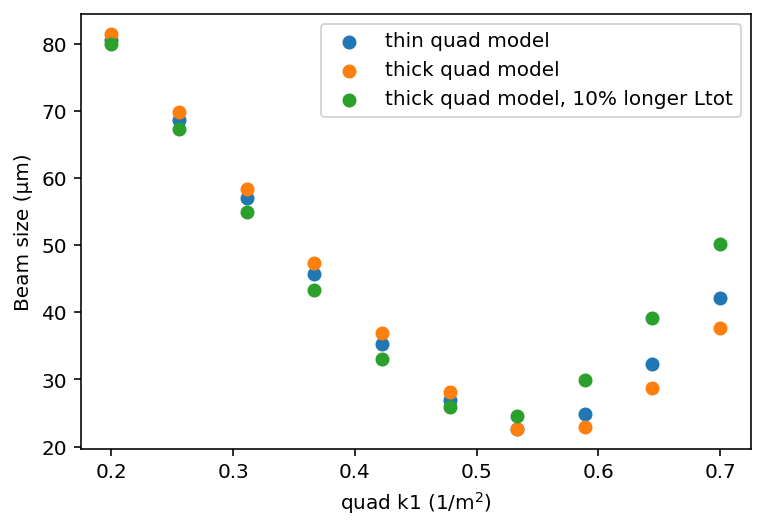

In [95]:
plt.scatter(kLlist, meas1*1e6, label='thin quad model')
plt.scatter(kLlist, meas2*1e6, label='thick quad model')
plt.scatter(kLlist, meas3*1e6, label='thick quad model, 10% longer Ltot')
#plt.scatter(klist, meas3*1e6, label='thick quad model, 10% higher Lquad')
plt.xlabel(r'quad k1 (1/m$^2$)')
plt.ylabel('Beam size (µm)')
plt.legend()

# Simple thin quad Reconstruction

In [96]:
import numpy.polynomial.polynomial as poly

def estimate_sigma_mat_thin_quad_drift(sizes, kLlist, d=2.26, plot=True):
    """
    Estimates the beam sigma matrix at a screen by scanning an upstream quad.
    This models the system as a thin quad.
    
    Parameters
    ----------
    sizes : array of float
        measured beam sizes at the screen
        
    kLlist : array of float
        kL of the upstream
        
    d : float
        distance from thin quad to the screen. 
    
    Returns
    -------
    
    sig_11_screen : array of float
    
    sig_12_screen : array of float
    
    sig_22_screen : tuple of float
    
    """

    
    coefs = poly.polyfit(kLlist, sizes**2, 2)

    c0, c1, c2 = coefs[0:3]
    
    # These are the inferred beam sigma matrix elements in front of quad
    sig_11 = c2 / d**2
    sig_12 = (-c1 - 2*d*sig_11) / (2*d**2)
    sig_22 = (c0 - sig_11 - 2*d*sig_12) / d**2
    emit2 = sig_11*sig_22 - sig_12**2
    
    # Matrix form
    sigma0 = np.array([ [sig_11, sig_12], [sig_12, sig_22] ])
    
    
    # emittance^2 directly
    emit2 = (4*c0*c2 - c1**2) / (4 * d**4)
    emit = np.sqrt(emit2)
    
    # Propagate forward to the screen
    sig_11_screen = []
    sig_12_screen = []
    sig_22_screen = []
    
    for kL in kLlist:
        mat2 = quad_drift_mat2(kL, Lquad=0, Ltot=d)
        sigma1 = propagate_sigma(sigma0, mat2)
        sig_11_screen.append(sigma1[0,0])
        sig_12_screen.append(sigma1[0,1])        
        sig_22_screen.append(sigma1[1,1])        

    sig_11_screen = np.array(sig_11_screen)
    sig_12_screen = np.array(sig_12_screen)
    sig_22_screen = np.array(sig_22_screen)
        
    if plot:
        # Plot the data
        plt.scatter(kLlist, sizes**2, marker='x', label=f'emit: {emit*1e9:0.2f} nm')
        
        # Sanity check
        #plt.scatter(kLlist, sig_11_screen, marker='.', label=f'inferred emit: {emit*1e9:0.2f} nm')
        
        # plot the fit
        xfit = np.linspace(np.min(kLlist), np.max(kLlist), 100)
        plt.plot(xfit, poly.polyval(xfit, coefs))
        
        plt.xlabel('kL (1/m)')
        plt.ylabel(f'sizes^2 (m$^2$)')    
    
    return sig_11_screen, sig_12_screen, sig_22_screen

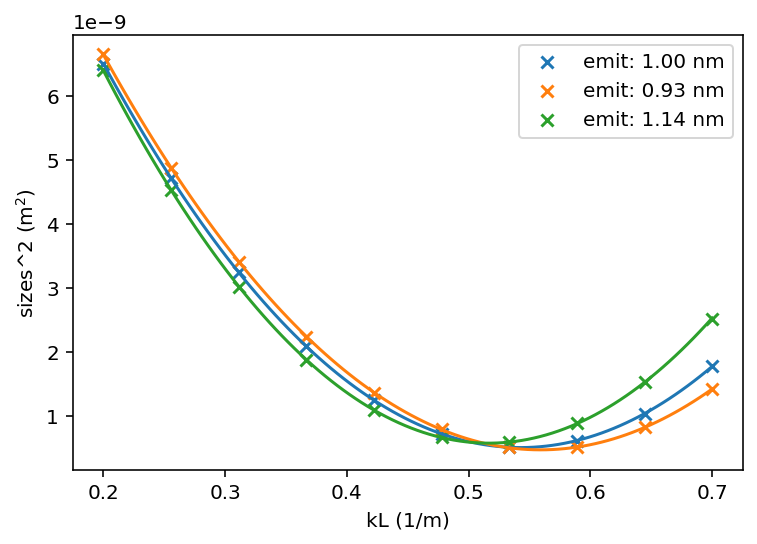

In [97]:
estimate_sigma_mat_thin_quad_drift(meas1, kLlist)
estimate_sigma_mat_thin_quad_drift(meas2, kLlist)
estimate_sigma_mat_thin_quad_drift(meas3, kLlist)
plt.legend()

# Pseudoinverse Method

This is better method, described in https://s3.cern.ch/inspire-prod-files-f/ffc80fb819125943207d0a1b2e71c32e


In [98]:
import scipy.linalg

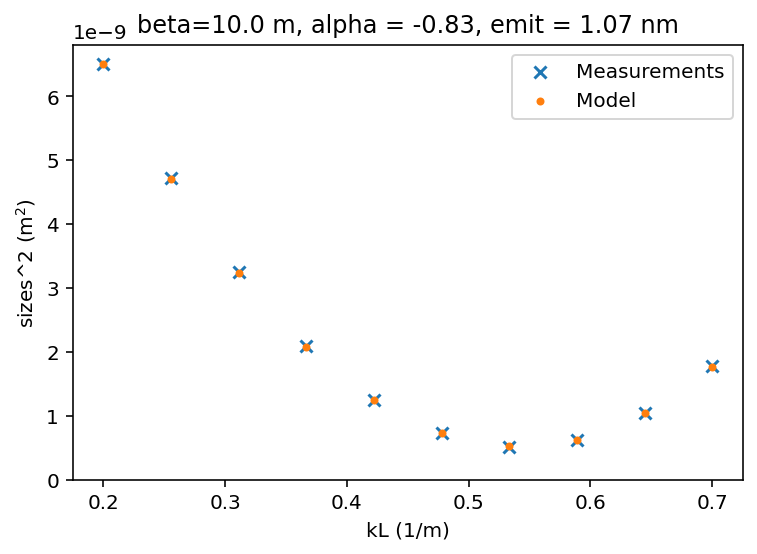

In [215]:
def estimate_sigma_mat_thick_quad_drift(sizes, kLlist, weights=None, Ltot=2.26, Lquad=0.108, plot=True):
    """
    Estimates the beam sigma matrix at a screen by scanning an upstream quad.

    This models the system as a thick quad.
    
    Parameters
    ----------
    sizes : array of float
        measured beam sizes at the screen
        
    kLlist : array of float
        kL of the upstream
        
        
    weights : array of float or None
        If present, each measurement will be weighted by this factor.
        
    Ltot : float
        total length in meters
    
    Lquad: float
        Length of the quadrupole magnet in meters
        
    plot : bool
    
    Returns
    -------
    
    s11_screen : array of float
    
    s12_screen : array of float
    
    s22_screen : tuple of float
    
    """    

    # measuerement vector
    b = sizes**2
    n = len(b)
    
    # Fill in defaults, checking. 
    if weights is None:
        weights = np.ones(n)
    assert len(weights) == n
    
    # Multiply by weights. This should corresond to the other weight multiplication below
    b = weights * sizes**2
    
    # form B matrix
    B = []
    # Collect mat2 for later
    mat2s = []
    for kL, weight in zip(kLlist, weights):
        mat2 = quad_drift_mat2(kL, Ltot=Ltot,  Lquad=Lquad)
        mat2s.append(mat2)
        r11, r12, r21, r22 = mat2.flatten()    
        B.append( np.array([ r11**2, 2*r11*r12, r12**2])*weight ) # correcponding weight multiplication
    B = np.array(B)    
    
    # Invert (pseudoinverse)
    s11, s12, s22 = scipy.linalg.pinv(B) @ b
    
    # Twiss calc just before the quad
    emit2 = s11*s22 - s12**2
    emit = np.sqrt(emit2)
    beta = s11/emit
    alpha = -s12/emit
    # gamma = s22/emit
    
    # Matrix form for propagation
    sigma0 = np.array([ [s11, s12], [s12, s22] ])
         
    # Propagate forward to the screen
    s11_screen = []
    s12_screen = []
    s22_screen = []
    for kL, mat2 in zip(kLlist, mat2s):
        sigma1 = propagate_sigma(sigma0, mat2)
        s11_screen.append(sigma1[0,0])
        s12_screen.append(sigma1[0,1])       
        s22_screen.append(sigma1[1,1])       
    s11_screen = np.array(s11_screen)
    s12_screen = np.array(s12_screen)
    s22_screen = np.array(s22_screen)

    if plot:
        # Plot the data
        plt.scatter(kLlist, sizes**2, marker='x', label=f'Measurements')
        
        # Model prediction
        plt.scatter(kLlist, s11_screen, marker='.', label=f'Model')
                
        plt.title(f'beta={beta:.1f} m, alpha = {alpha:0.2f}, emit = {emit*1e9:0.2f} nm')
        plt.xlabel('kL (1/m)')
        plt.ylabel(f'sizes^2 (m$^2$)')
        plt.ylim(0, None)
        plt.legend()
    
    return emit,s11_screen, s12_screen, s22_screen

# Data from thin quad 'simulation'
estimate_sigma_mat_thick_quad_drift(meas1, kLlist);

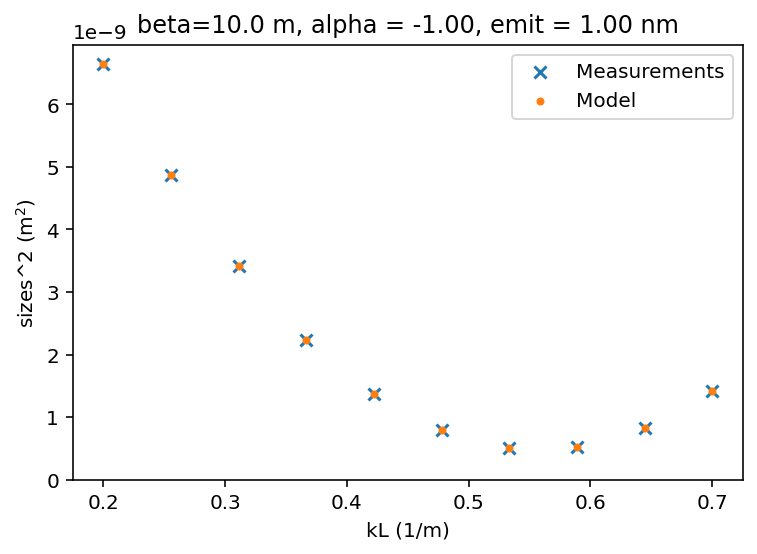

In [100]:
# Data from thick quad 'simulation' Note that this gets it exactly correct.
estimate_sigma_mat_thick_quad_drift(meas2, kLlist);

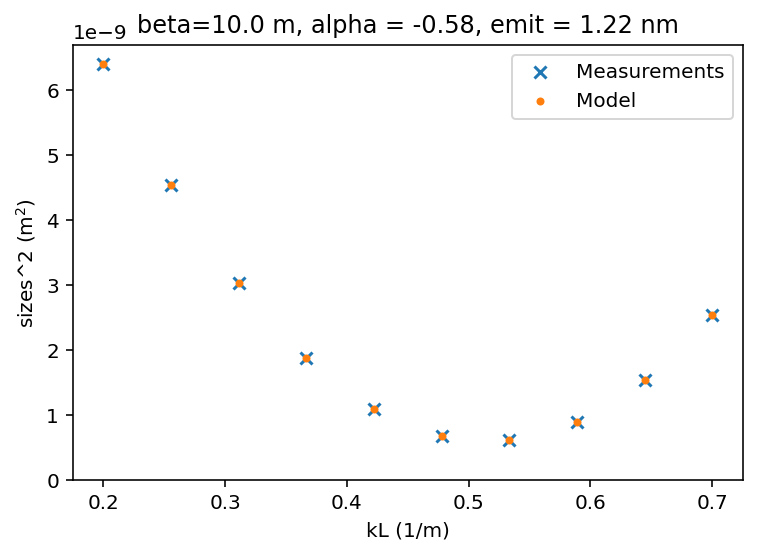

In [101]:
# Data from thick quad 'simulation' with 10% longer drift
estimate_sigma_mat_thick_quad_drift(meas3, kLlist);

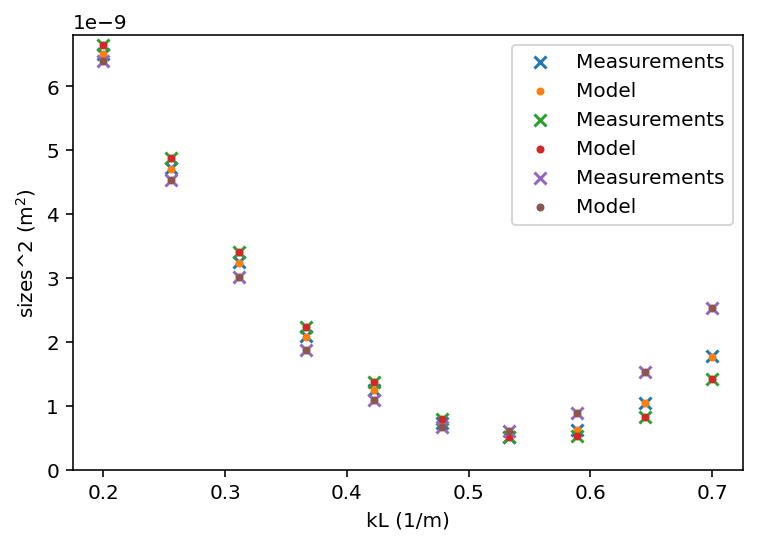

In [102]:
# All together
estimate_sigma_mat_thick_quad_drift(meas1, kLlist);
estimate_sigma_mat_thick_quad_drift(meas2, kLlist);
estimate_sigma_mat_thick_quad_drift(meas3, kLlist);
plt.title('');

# Bmag

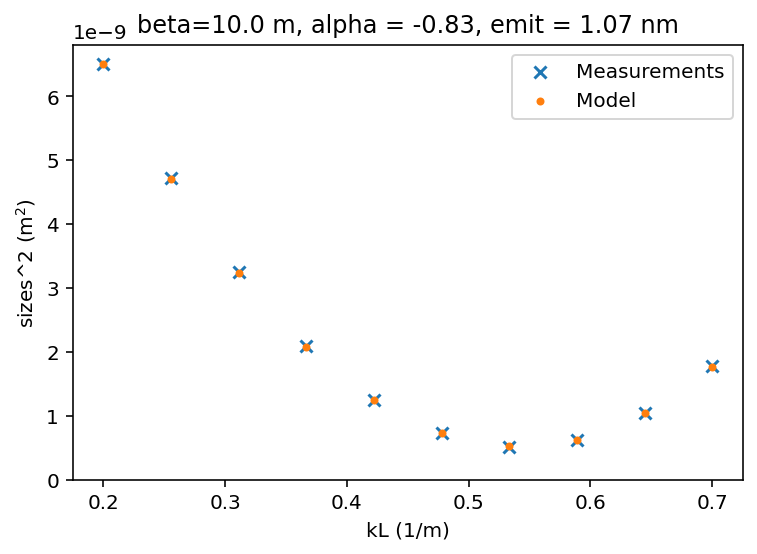

In [103]:
sig_11_screen, sig_12_screen, sig_22_screen = estimate_sigma_mat_thick_quad_drift(meas1, kLlist)

In [242]:
def twiss_and_bmag(sig_11, sig_12, sig_22, beta0=1, alpha0=0):
    """
    Calculates Twiss ang Bmag from the sigma matrix.
    
    Note that px here is x'
    """
    emit  = np.sqrt(sig_11 * sig_22 - sig_12**2) 
    beta  = sig_11/emit
    alpha = -sig_12/emit
    gamma = sig_22/emit
    
    # Form bmag
    gamma0 = (1+alpha0**2)/beta0
    bmag = (beta * gamma0 - 2*alpha * alpha0 + gamma * beta0) / 2
    
    d = {}
    d['emit'] = emit
    d['beta'] = beta
    d['alpha'] = alpha
    d['bmag'] = bmag
    
    return d

In [243]:
res = twiss_and_bmag(sig_11_screen, sig_12_screen, sig_22_screen)

(0.0, 3.2556094359553263)

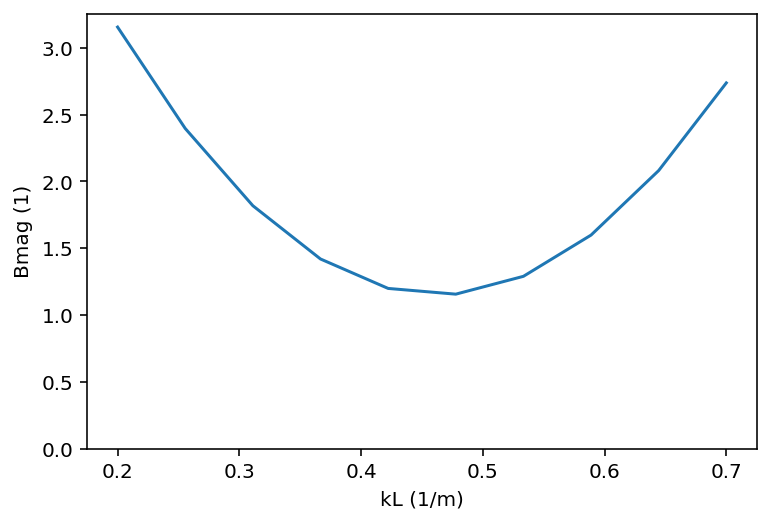

In [244]:
fig, ax = plt.subplots()

ax.plot(kLlist, res['bmag'])
ax.set_xlabel('kL (1/m)')
ax.set_ylabel('Bmag (1)')
ax.set_ylim(0, None)

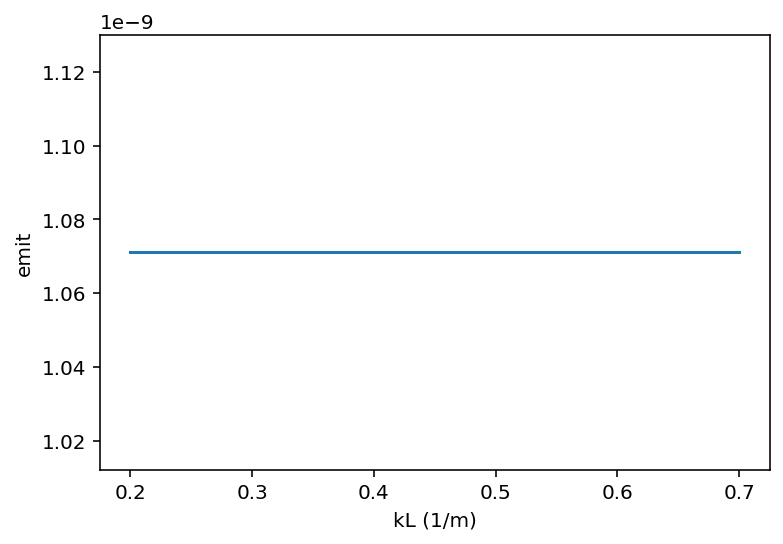

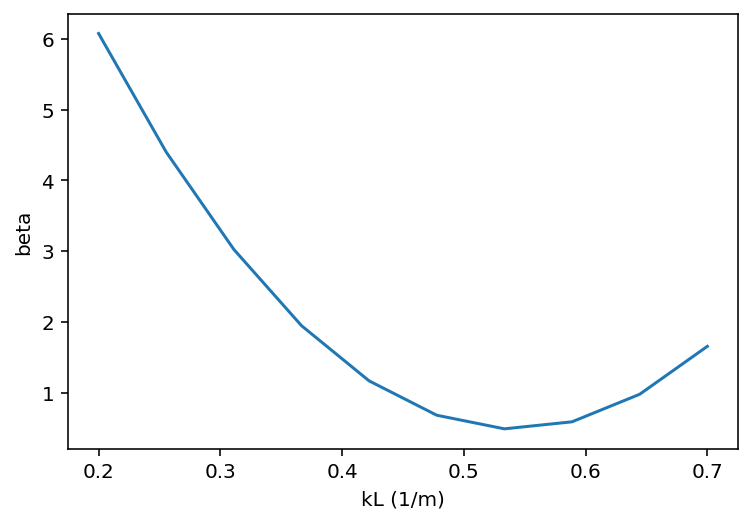

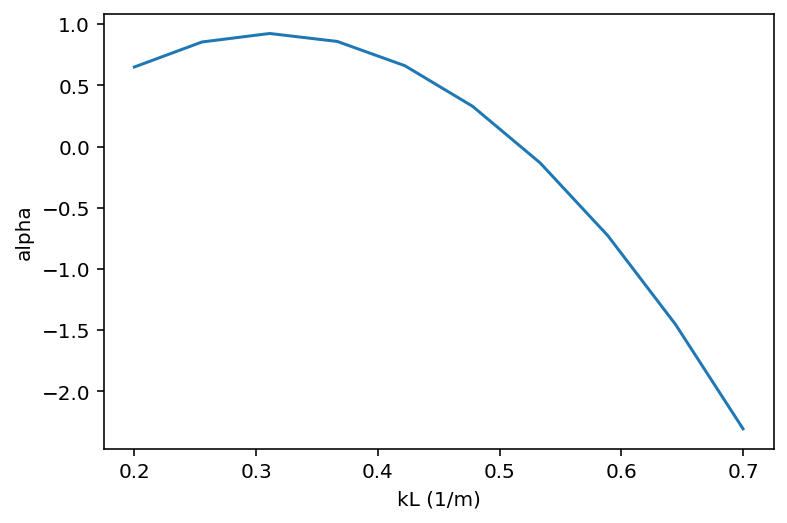

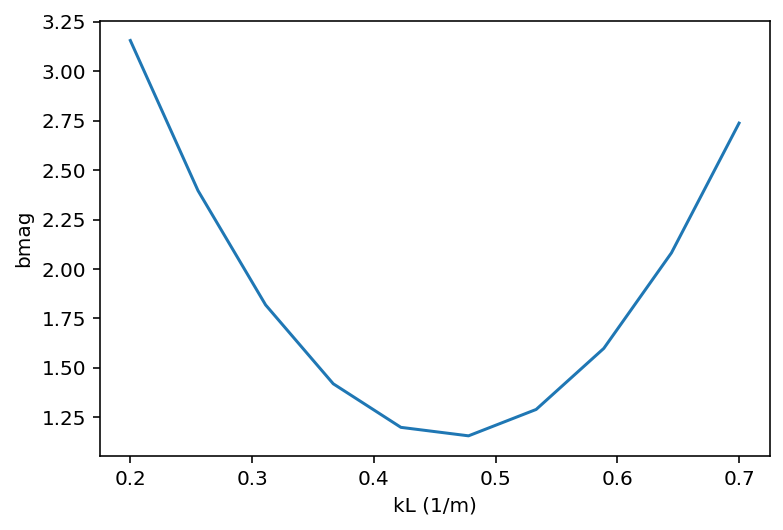

In [245]:
# All plots
for k in res:
    fig, ax = plt.subplots()
    
    ax.plot(kLlist, res[k])
    ax.set_xlabel('kL (1/m)')
    ax.set_ylabel(k)
    
    

## AUTOMATE MEASUREMENT

In [797]:
kLlist = np.linspace(0.2, 0.7, 10)

# Make the data
meas1 =  np.array([model3(k) for k in kLlist])

In [798]:
meas1

array([8.00083756e-05, 6.72884546e-05, 5.49532743e-05, 4.33077842e-05,
       3.30559179e-05, 2.58671596e-05, 2.45495143e-05, 2.98541857e-05,
       3.91506137e-05, 5.02499672e-05])

In [799]:
class Observer:
    '''
    Observer reads beamsizes and sets measurement quad
    Observer stores values for beamsizes and quad settings
    
    '''
    def __init__(self,quad_meas=np.empty(0,),beam_meas={'x': np.empty(0,), 'y': np.empty(0,)}):
        self.quad_meas = quad_meas
        self.beam_meas = beam_meas
        self.use_model = True
        
    def measure_beam(self,):
        
        if self.use_model == True:
            
            xrms = np.array(model1(self.quad_meas[-1]))
            yrms = np.array(model1(self.quad_meas[-1]))
            
        if self.use_model == False:
            #todo: add code for machine io
            pass
            
        self.beam_meas['x'] = np.concatenate((self.beam_meas['x'],np.array([xrms])))
        self.beam_meas['y'] = np.concatenate((self.beam_meas['y'],np.array([yrms])))
        
        return xrms, yrms
    
    
    def set_quad(self,quad_val):
        
        if self.use_model == True:
            pass
            
        if self.use_model == False:
            #todo: add code for machine io
            #set quad
            #read quad back as quad_val
            pass
            
        self.quad_meas = np.concatenate((self.quad_meas,np.array([quad_val])))
        

           

In [800]:
kLlist = np.linspace(0.2, 0.7, 10)

# Make the data
meas1 =  np.array([model3(k) for k in kLlist])

o1 = Observer(kLlist, {'x': meas1 ,'y': meas1} )


In [801]:
o1.quad_meas

array([0.2       , 0.25555556, 0.31111111, 0.36666667, 0.42222222,
       0.47777778, 0.53333333, 0.58888889, 0.64444444, 0.7       ])

In [802]:
o1.set_quad(0.8)

In [803]:
o1.beam_meas

{'x': array([8.00083756e-05, 6.72884546e-05, 5.49532743e-05, 4.33077842e-05,
        3.30559179e-05, 2.58671596e-05, 2.45495143e-05, 2.98541857e-05,
        3.91506137e-05, 5.02499672e-05]),
 'y': array([8.00083756e-05, 6.72884546e-05, 5.49532743e-05, 4.33077842e-05,
        3.30559179e-05, 2.58671596e-05, 2.45495143e-05, 2.98541857e-05,
        3.91506137e-05, 5.02499672e-05])}

In [804]:
o1.measure_beam()

(array(6.24339651e-05), array(6.24339651e-05))

In [805]:
o1.beam_meas

{'x': array([8.00083756e-05, 6.72884546e-05, 5.49532743e-05, 4.33077842e-05,
        3.30559179e-05, 2.58671596e-05, 2.45495143e-05, 2.98541857e-05,
        3.91506137e-05, 5.02499672e-05, 6.24339651e-05]),
 'y': array([8.00083756e-05, 6.72884546e-05, 5.49532743e-05, 4.33077842e-05,
        3.30559179e-05, 2.58671596e-05, 2.45495143e-05, 2.98541857e-05,
        3.91506137e-05, 5.02499672e-05, 6.24339651e-05])}

In [806]:
 class EmitFitter:
    '''
    Uses info recorded in Observer to do an emittance fit
    
    '''
    def __init__(self, quad_vals = np.empty(0,), beam_vals = {'x': np.empty(0,), 'y': np.empty(0,)}):
        self.quad_vals = quad_vals
        self.beam_vals = beam_vals
        self.x_use = np.arange(0,len(beam_vals['x']),1)
        self.y_use = np.arange(0,len(beam_vals['y']),1)
        
        self.sig_11 = []
        self.sig_12 = []
        self.sig_22 = []
        self.test_mode = False
        self.noise_red = 50000#500000000000#5
        
    def check_conditions(self,):
        
        self.x_use = np.arange(0,len(beam_vals['x']),1)
        self.y_use = np.arange(0,len(beam_vals['y']),1)
        
        minx = np.min(self.beam_vals['x'])
        miny = np.min(self.beam_vals['y'])
        
        self.x_use = np.argwhere(self.beam_vals['x'] < 2.0*minx)
        self.y_use = np.argwhere(self.beam_vals['y'] < 2.0*miny)
        
        
    def weighting_func(self, beamsizes):
        weights = 1/beamsizes
        return weights
    
        
    
    def do_emit_fit(self,dim = 'x'):
        
        #todo update based on x_use, y_use for throwing away fit points
        q = self.quad_vals 
        
        bs = self.beam_vals[dim] 
        
        weights = self.weighting_func(bs)
        
        if self.test_mode == False:
        
            emit, self.sig_11, self.sig_12 , self._sig_22 = estimate_sigma_mat_thick_quad_drift(bs, q, weights)
            plt.show()
        
        if self.test_mode == True:

            bs = bs + np.random.rand(len(bs))/self.noise_red
            print("NOISE")
            emit, self.sig_11, self.sig_12 , self._sig_22  = estimate_sigma_mat_thick_quad_drift(bs, q, weights)
            plt.show()
        
        err = np.std(np.absolute(self.sig_11 - bs))
        
        return emit, err

        
    

## Example using observer and emittane classes

In [885]:
kLlist = np.linspace(0.2, 0.7, 10)

# Make the data
meas1 =  np.array([model3(k) for k in kLlist])

o1 = Observer(kLlist, {'x': meas1 ,'y': meas1} )

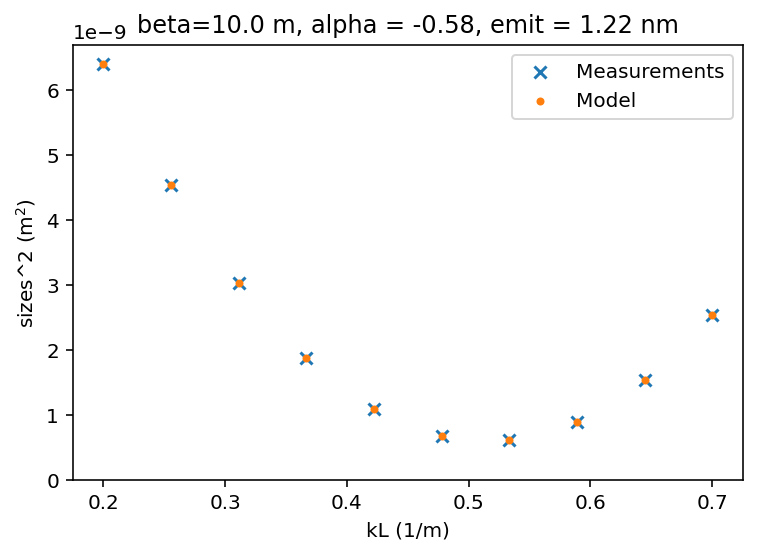

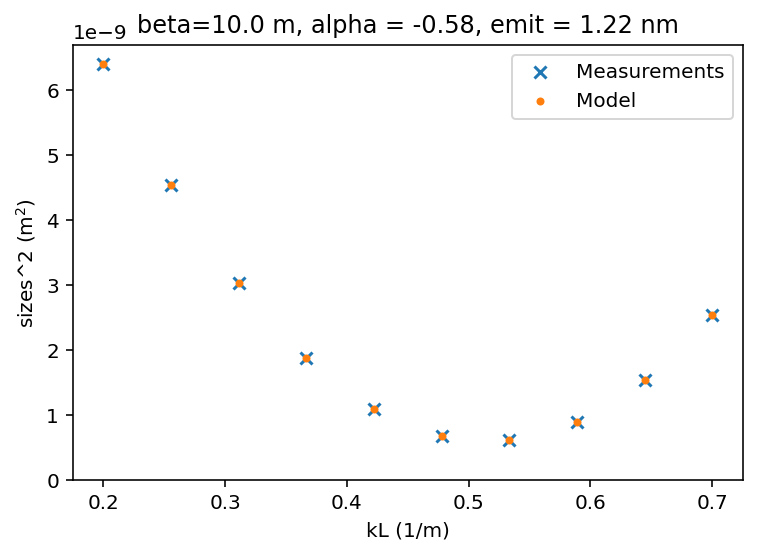

In [886]:
ef1 = EmitFitter(o1.quad_meas,o1.beam_meas)
emitx, erry = ef1.do_emit_fit(dim='x')
emity, erry = ef1.do_emit_fit(dim='y')

# Bayesian Exploration of Emit Calc

In [933]:
def get_BO_point(x, f, bounds, precision, beta=1e9, sigma_mult = 1e-10, opt=False):
    """

    function that trains a GP model of data and returns the next observation point using UCB
    D is input space dimensionality
    N is number of samples

    :param x: input points data, torch.tensor, shape (N,D)
    :param f: output point data, torch.tensor, shape (N,1)
    :param bounds: input space bounds, torch.tensor, shape (2,D)
    :param beta: UCB optimization parameter, float
    :return x_candidate, model: next observation point and gp model w/observations
    """

    # define GP model
    D = x.shape[-1]

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    gp = botorch.models.SingleTaskGP(x, f)
    
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)

    for name, item in gp.named_parameters():
        print(f'{name}:{item}')

    # fit GP hyperparameters
    print('training hyperparameters')
    botorch.fit.fit_gpytorch_model(mll)

    # do acquisition
    print('optimizing acquisition function')
    
    prox = proximal.ProximalAcqusitionFunction(gp, sigma_matrix=torch.eye(1)*sigma_mult)
    UCB = botorch.acquisition.UpperConfidenceBound(gp, beta=beta)
    comb = combine_acquisition.MultiplyAcquisitionFunction(gp, [prox, UCB])

    
    candidate, acq_value = botorch.optim.optimize_acqf(comb,
                                                       bounds=bounds,
                                                       q=1,
                                                       num_restarts=10,
                                                       raw_samples=20)
    
    if opt == True:
        UCB = botorch.acquisition.UpperConfidenceBound(gp, beta=2.0)
        candidate, acq_value = botorch.optim.optimize_acqf(UCB,
                                                       bounds=bounds,
                                                       q=1,
                                                       num_restarts=10,
                                                       raw_samples=20)
        
    return candidate, gp

In [934]:
class Standardizer():
    
    '''
    Standardizes data
    '''
    def __init__(self, mean = 0.0, std = 1.0):
        self.mean = mean
        self.std = std
        self.grab_stats=True

    def normalize_data(self,x_in,grab_stats=True):
        if grab_stats:
            self.mean = x_in.mean()
            self.std = x_in.std()
            
        x_out=(x_in-self.mean)/self.std
        return x_out 

    def un_normalize_data(self,x_out):

        x_in = x_out*self.std + self.mean
        return x_in 
    
x_in = np.array([0.2,0.8])
nq = Standardizer()
x_out = nq.normalize_data(x_in)
print(x_out)
x_in = nq.un_normalize_data(x_out)
print(x_in)

[-1.  1.]
[0.2 0.8]


In [935]:

def bayes_exp_next(q,x,y):
    
    '''
    get next quad point from bayes exp
    '''

    next_point_x = get_BO_point(torch.as_tensor(q).reshape((len(q),1)), torch.as_tensor(-1*x).reshape((len(x),1)),bounds,None)
    print(next_point_x[0][0][0])
    next_point_x = nq.un_normalize_data(np.array(next_point_x[0][0][0]))
    print(next_point_x)


    o1.set_quad(next_point_x)
    o1.measure_beam()


    #todo - add for asymmetric x and y
    #next_point_y = get_BO_point(torch.as_tensor(q).reshape((len(q),1)), torch.as_tensor(-1*y).reshape((len(y),1)),bounds,None)
    #next_point_y = np.array(next_point_y[0][0][0])
    #next_point_y = nq.un_normalize_data(np.array(next_point_y[0][0][0]))


    #o1.set_quad(next_point_y)
    #o1.measure_beam()
    
    

In [936]:

def bayes_opt_next(q,x,y):
    
    '''
    get next quad point from bayes exp
    '''

    next_point_x = get_BO_point(torch.as_tensor(q).reshape((len(q),1)), torch.as_tensor(-1*x).reshape((len(x),1)),bounds,None,opt=True)
    print(next_point_x[0][0][0])
    next_point_x = nq.un_normalize_data(np.array(next_point_x[0][0][0]))
    print(next_point_x)


    o1.set_quad(next_point_x)
    o1.measure_beam()


    #todo - add for asymmetric x and y
    #next_point_y = get_BO_point(torch.as_tensor(q).reshape((len(q),1)), torch.as_tensor(-1*y).reshape((len(y),1)),bounds,None)
    #next_point_y = np.array(next_point_y[0][0][0])
    #next_point_y = nq.un_normalize_data(np.array(next_point_y[0][0][0]))


    #o1.set_quad(next_point_y)
    #o1.measure_beam()
    

## start with even initial points

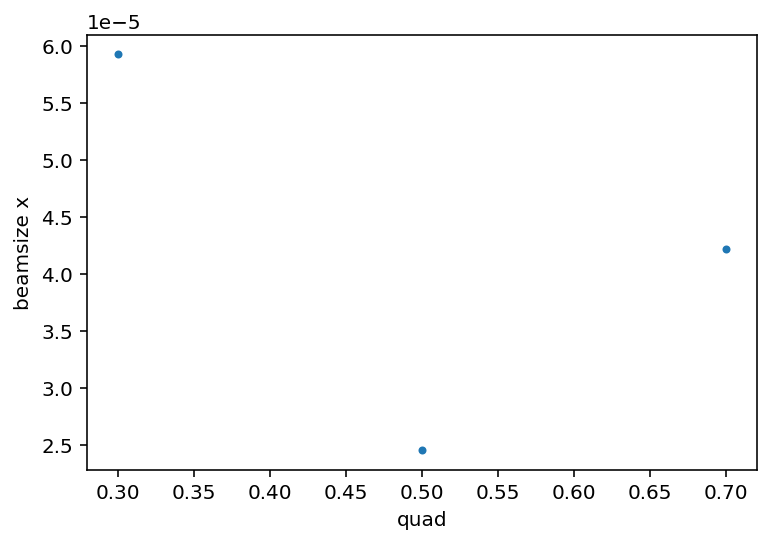

In [952]:
bounds_full = np.array([0.2,0.7])

# Initialize Standardizers
q_in_range = np.array([0.2,0.7])
nq = Standardizer()
nq.normalize_data(q_in_range)
nx = Standardizer()
ny = Standardizer()

# Make the data
kLlist = np.linspace(0.3, 0.7, 3)
meas1 =  np.array([model1(k) for k in kLlist])

# Initialize observer
o1 = Observer(kLlist, {'x': meas1 ,'y': meas1} )

number_to_sample = 10 

plt.plot(kLlist,meas1,'.')
plt.xlabel('quad')
plt.ylabel('beamsize x')
plt.show()


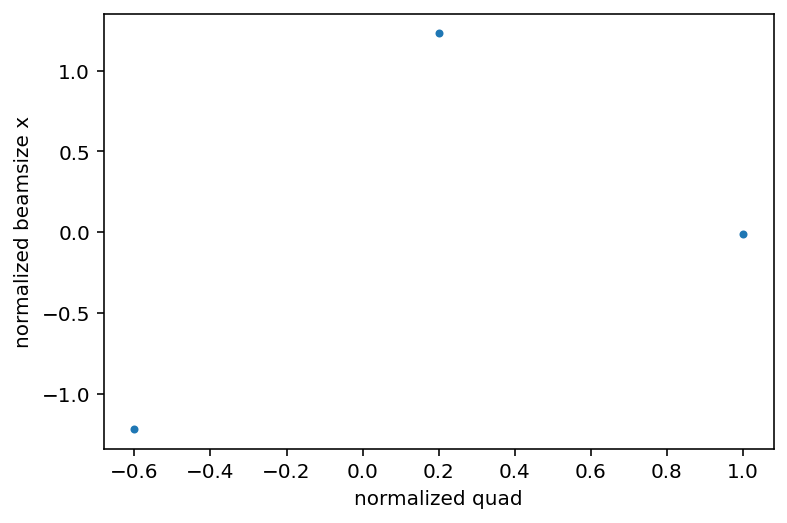

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(0.4634)
0.5658433184027671


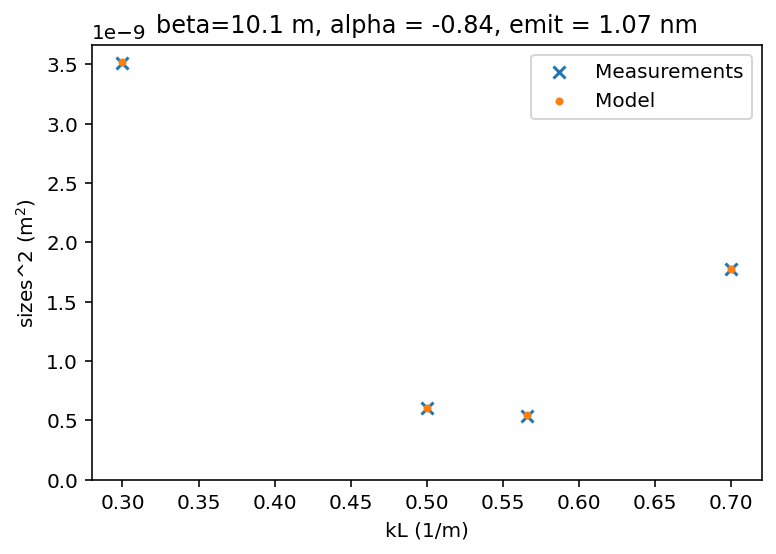

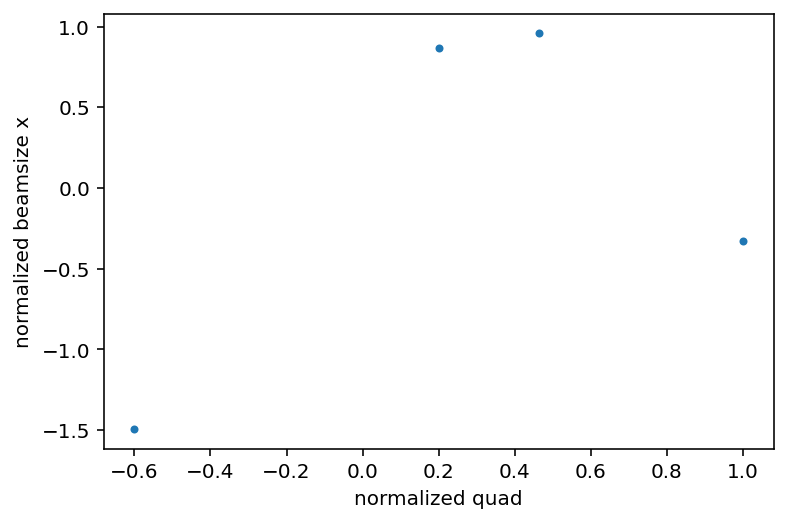

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(0.3441)
0.5360276594758033


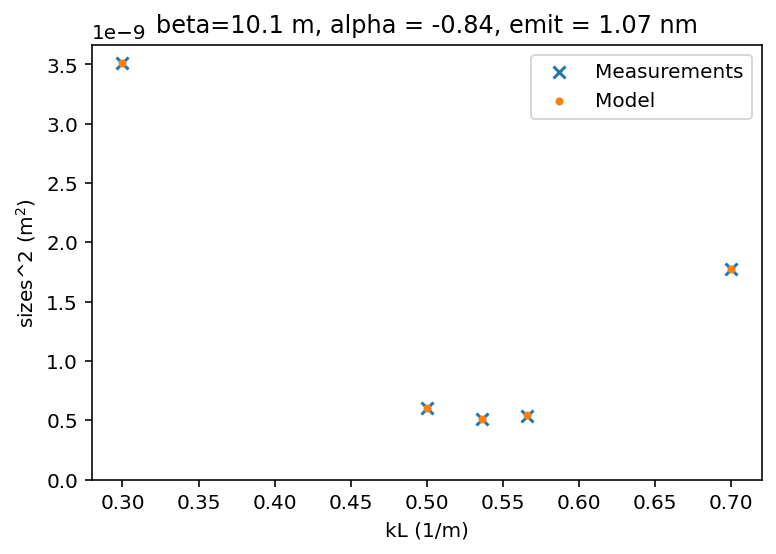

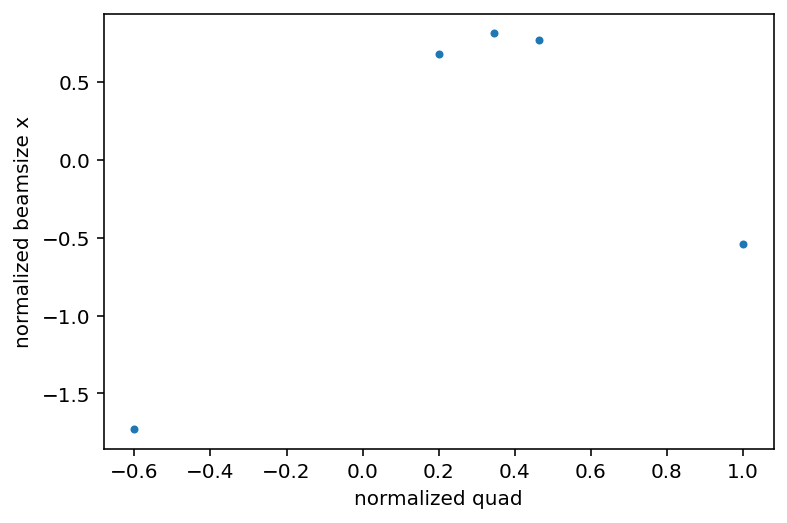

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(-0.9944)
0.20140535831451414


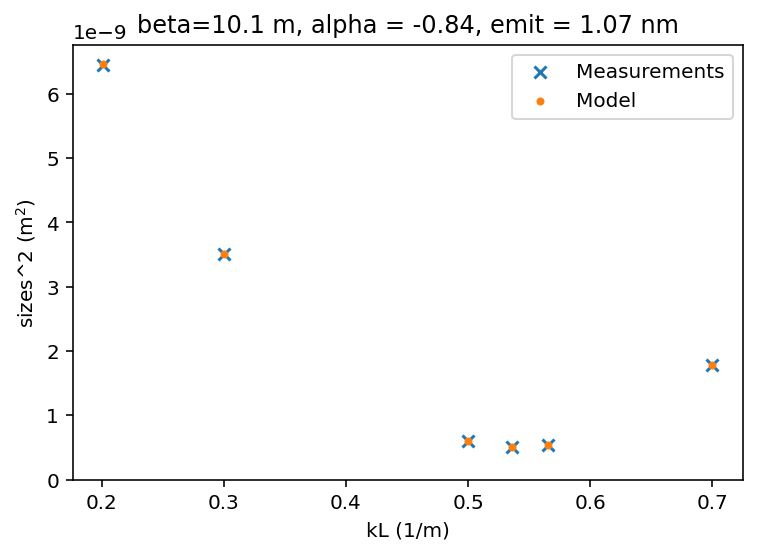

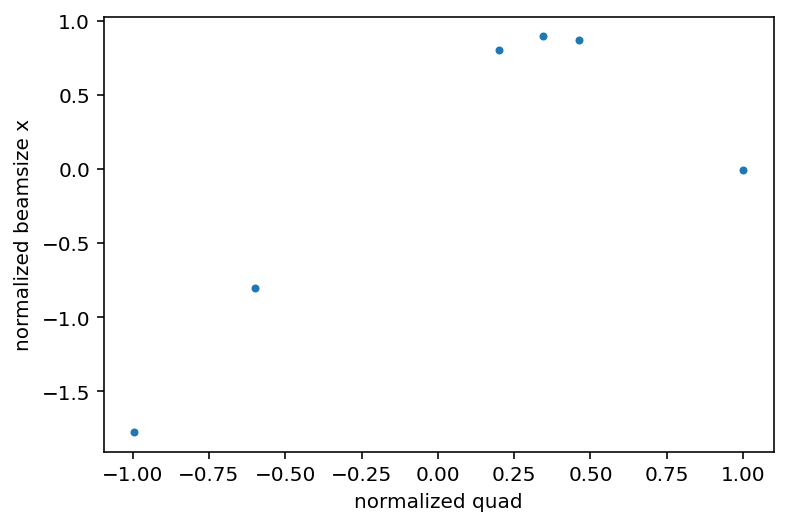

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(-0.6686)
0.2828529298305511


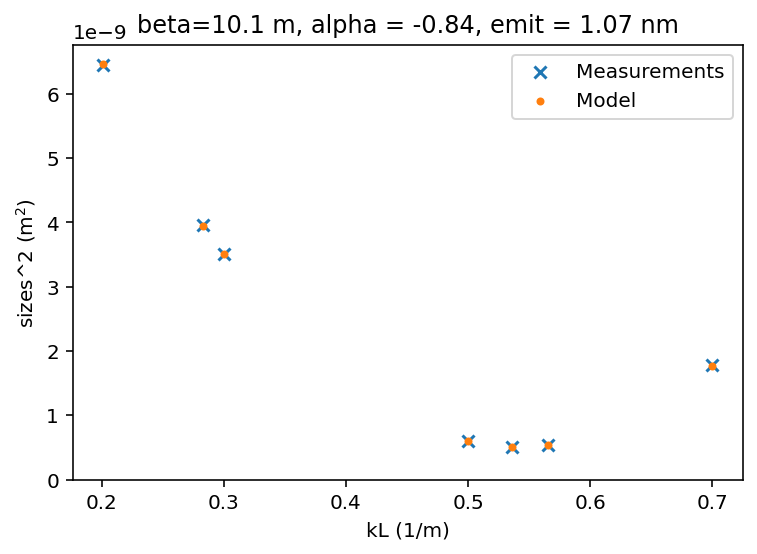

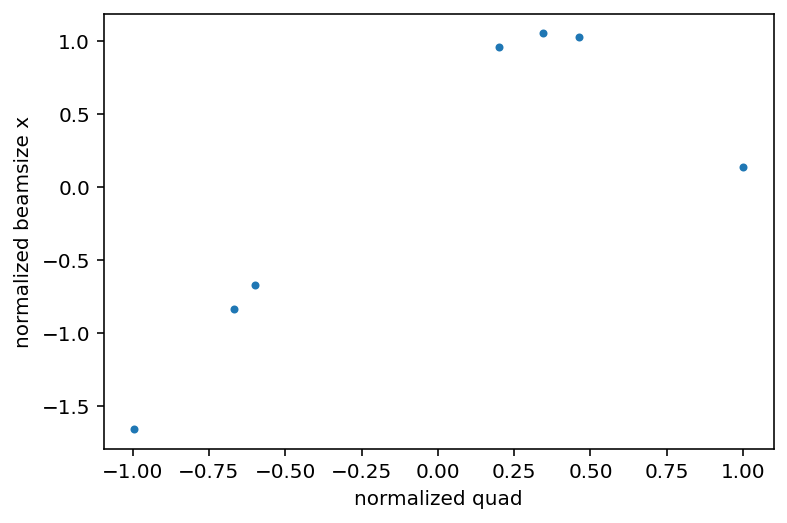

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(-0.1287)
0.4178156524896621


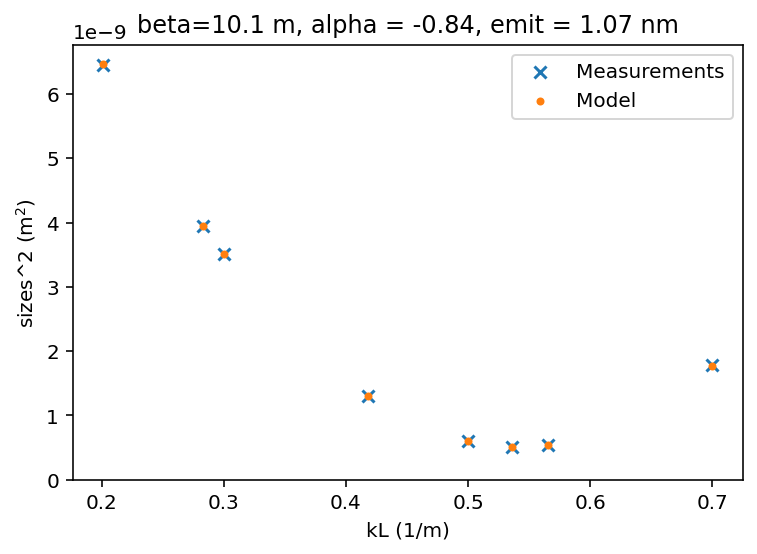

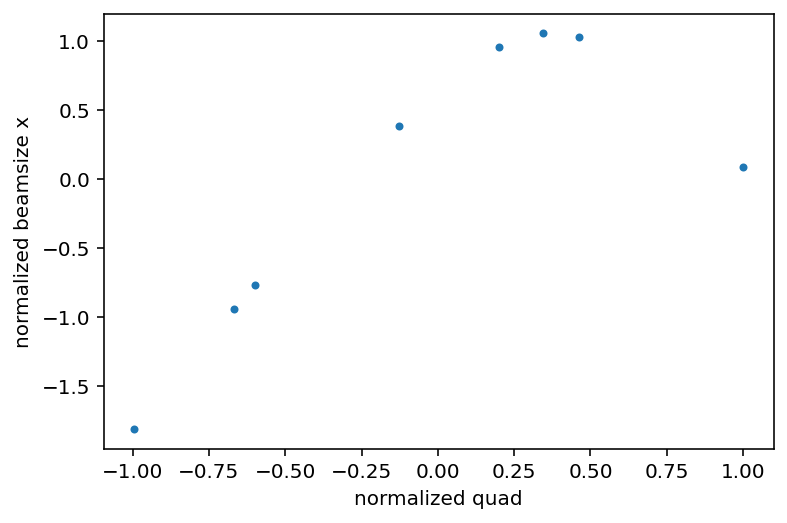

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(0.1560)
0.48898939490318294


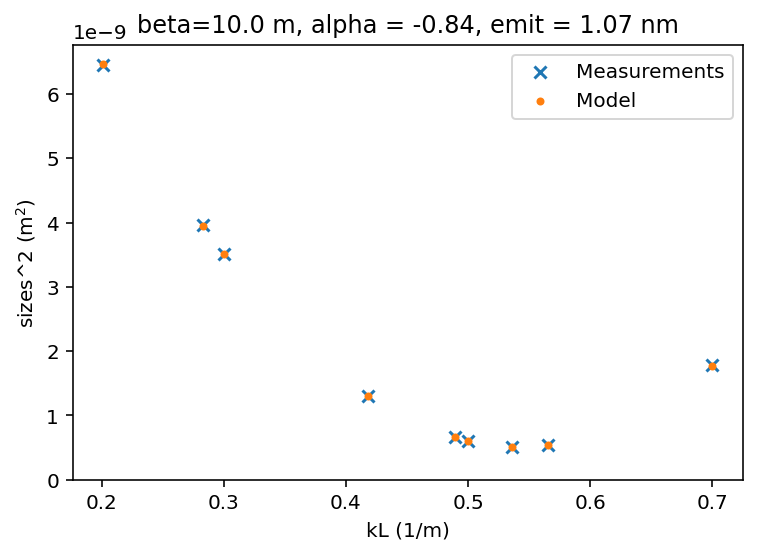

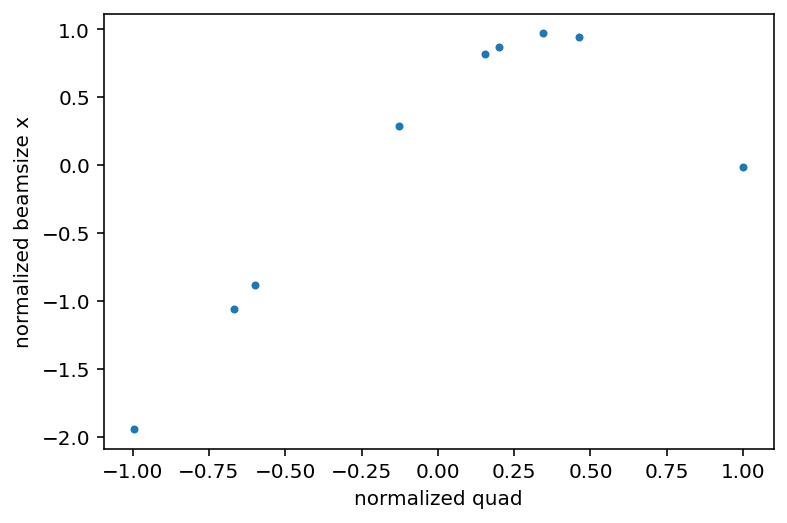

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(0.0090)
0.45223985314369197


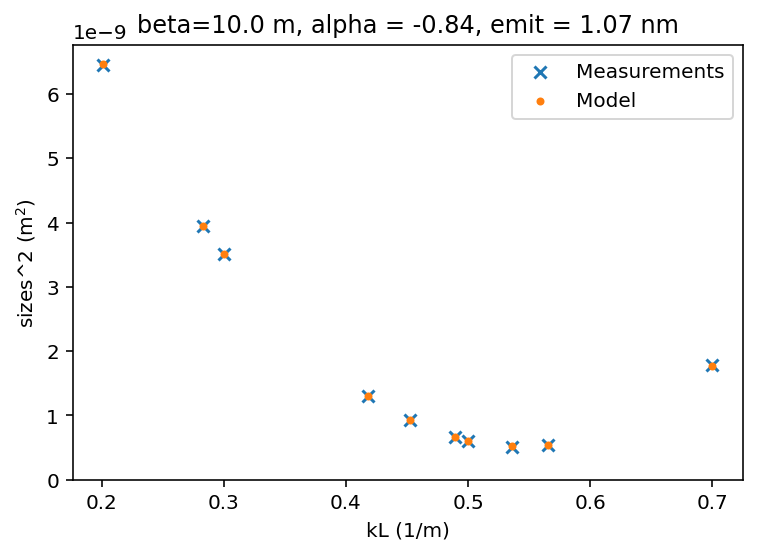

In [953]:
while (len(o1.quad_meas) < number_to_sample/2):
    
    q = nq.normalize_data(o1.quad_meas,grab_stats=False)
    x = nx.normalize_data(o1.beam_meas['x'])
    y = ny.normalize_data(o1.beam_meas['y'])
    
    plt.plot(q,-1*x,'.')
    plt.xlabel('normalized quad')
    plt.ylabel('normalized beamsize x')
    plt.show()

    bounds_n = nq.normalize_data(bounds_full,grab_stats=False)
    print(bounds_n)
    bounds = torch.stack([bounds_n[0]*torch.ones(1), bounds_n[1]*torch.ones(1)])
    
    bayes_opt_next(q,x,y)
    
    ef1 = EmitFitter(o1.quad_meas,o1.beam_meas)
    
    emitx, errx = ef1.do_emit_fit(dim='x')
    #emity, erry = ef1.do_emit_fit(dim='y')


while (len(o1.quad_meas) < number_to_sample):
    
    q = nq.normalize_data(o1.quad_meas,grab_stats=False)
    x = nx.normalize_data(o1.beam_meas['x'])
    y = ny.normalize_data(o1.beam_meas['y'])
    
    plt.plot(q,-1*x,'.')
    plt.xlabel('normalized quad')
    plt.ylabel('normalized beamsize x')
    plt.show()

    bounds_n = nq.normalize_data(bounds_full,grab_stats=False)
    print(bounds_n)
    bounds = torch.stack([bounds_n[0]*torch.ones(1), bounds_n[1]*torch.ones(1)])
    
    bayes_exp_next(q,x,y)
    
    ef1 = EmitFitter(o1.quad_meas,o1.beam_meas)
    
    emitx, errx = ef1.do_emit_fit(dim='x')
    #emity, erry = ef1.do_emit_fit(dim='y')

## start with asymmetric initial points

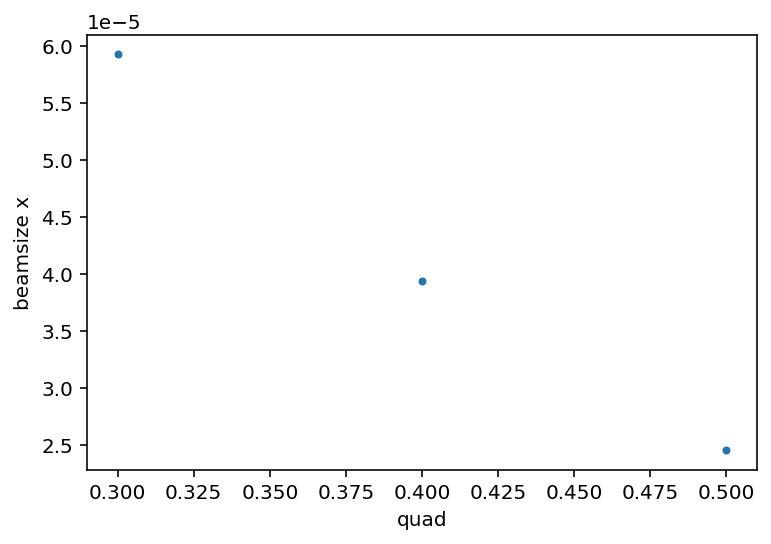

In [954]:
bounds_full = np.array([0.2,0.7])

# Initialize Standardizers
q_in_range = np.array([0.2,0.7])
nq = Standardizer()
nq.normalize_data(q_in_range)
nx = Standardizer()
ny = Standardizer()

# Make the data
kLlist = np.linspace(0.3, 0.5, 3)
meas1 =  np.array([model1(k) for k in kLlist])

# Initialize observer
o1 = Observer(kLlist, {'x': meas1 ,'y': meas1} )

number_to_sample = 10 

    
plt.plot(kLlist,meas1,'.')
plt.xlabel('quad')
plt.ylabel('beamsize x')
plt.show()


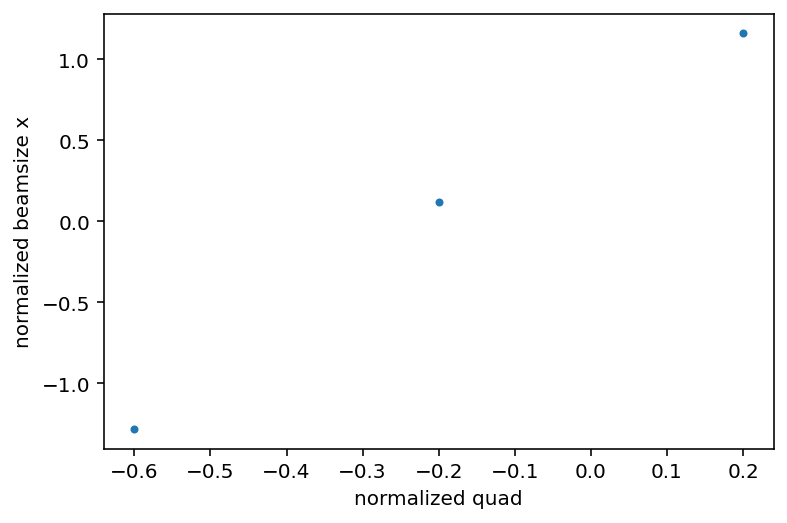

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(0.6202)
0.6050473272800445


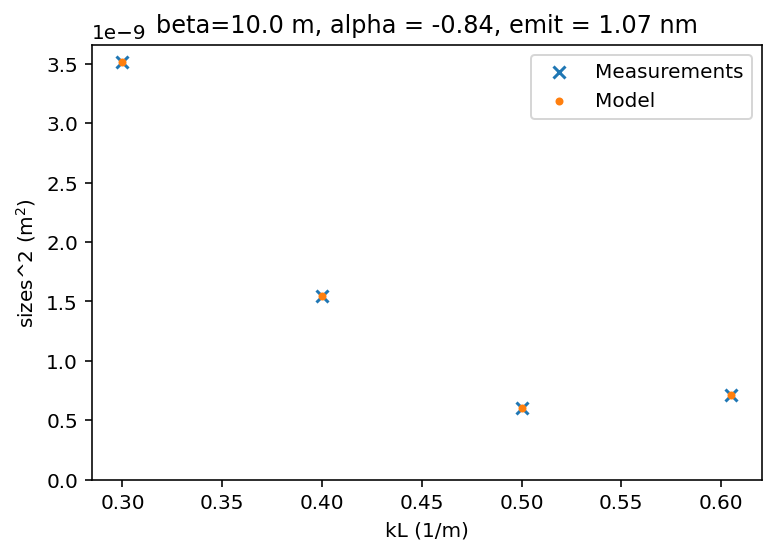

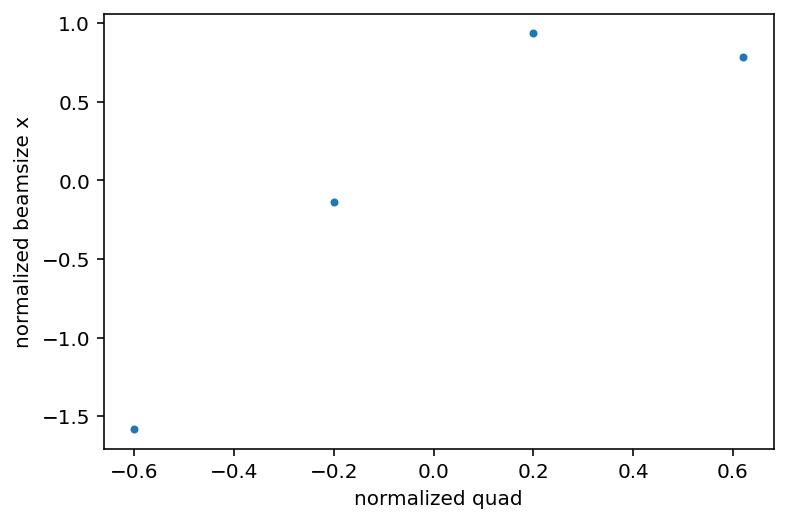

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(1.)
0.7


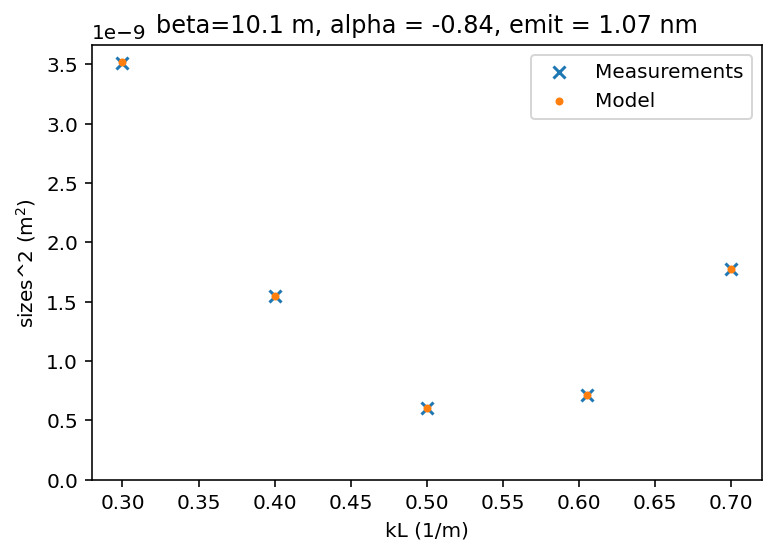

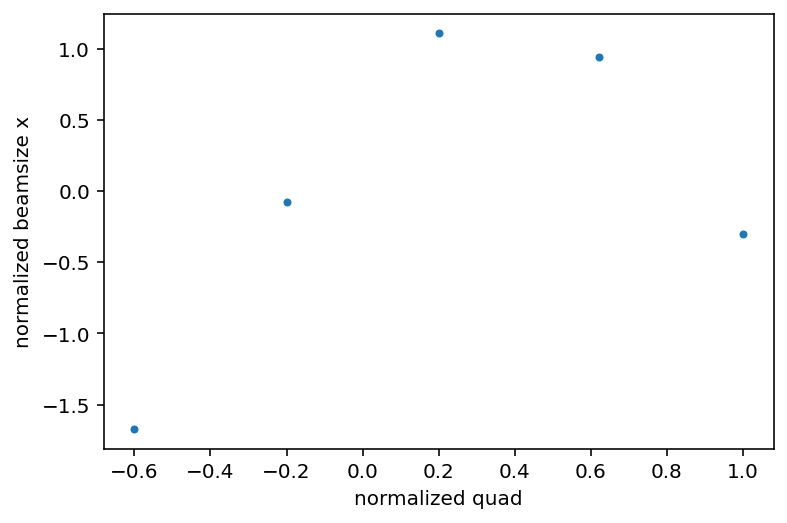

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(0.4716)
0.5678995370864868


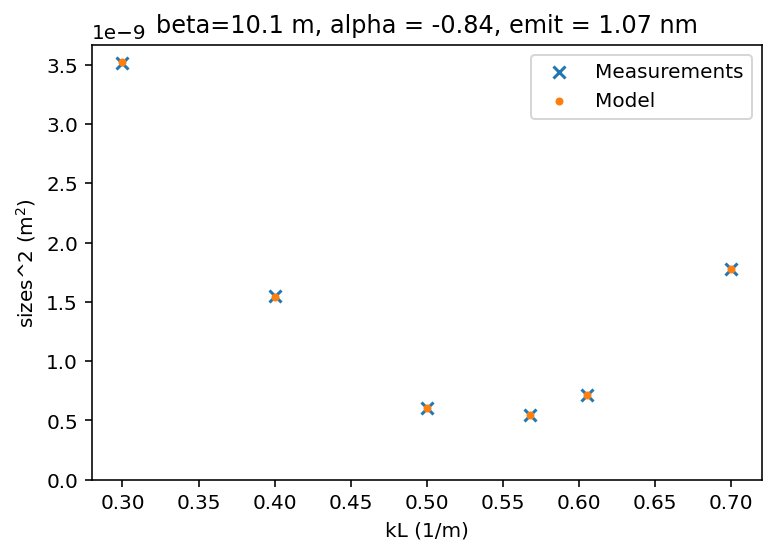

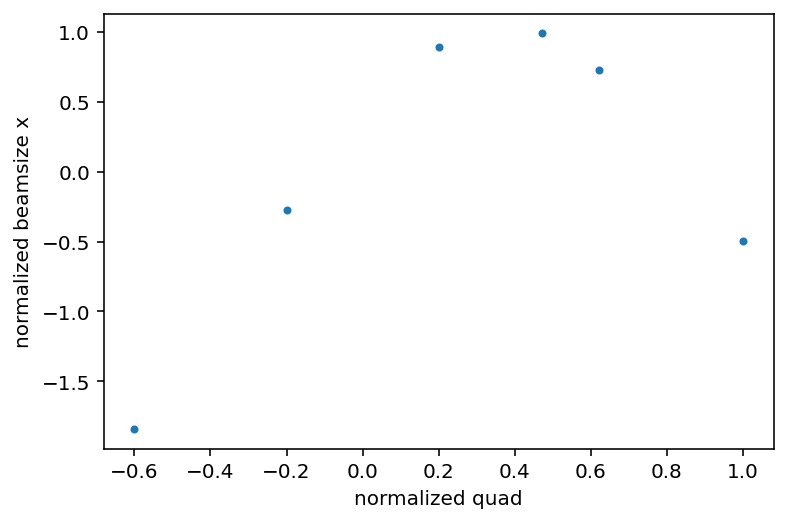

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(0.2528)
0.5131920397281646


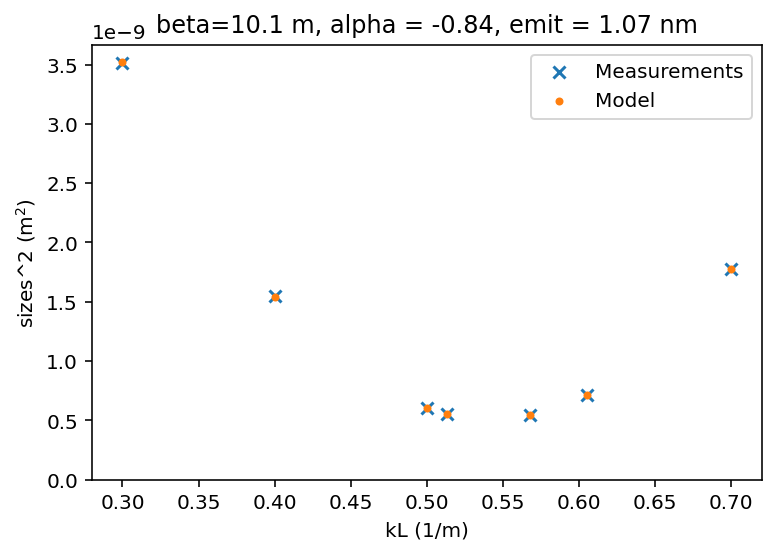

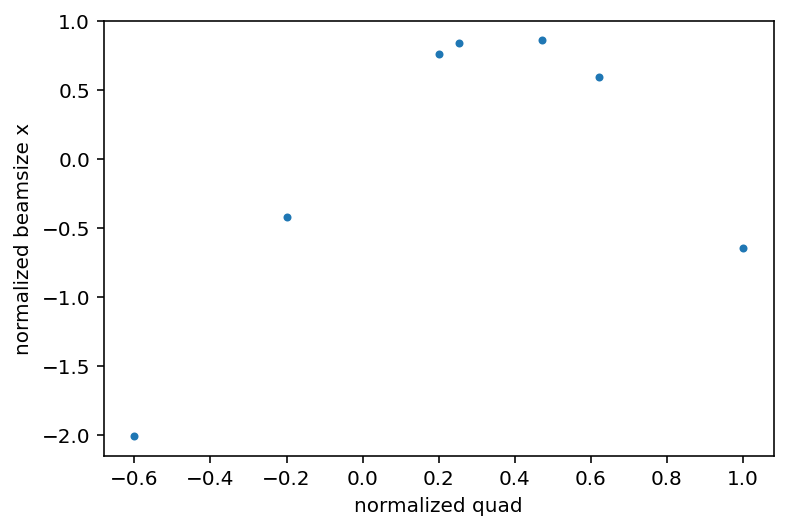

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(0.4899)
0.5724741041660308


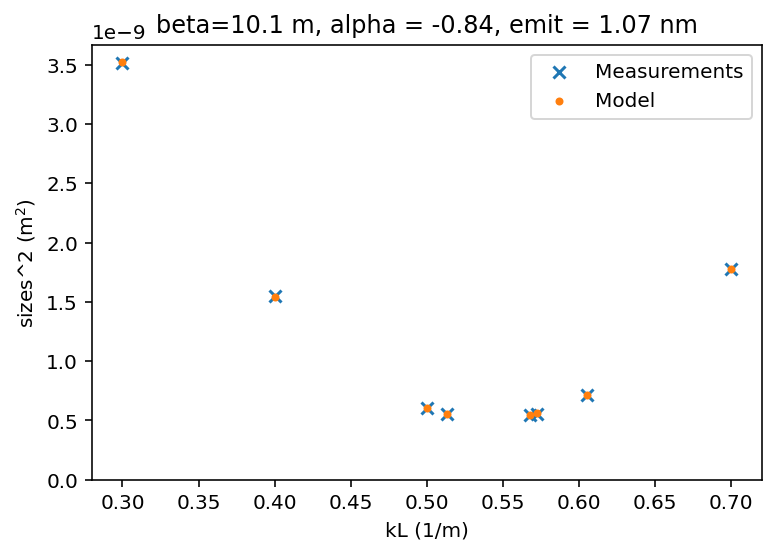

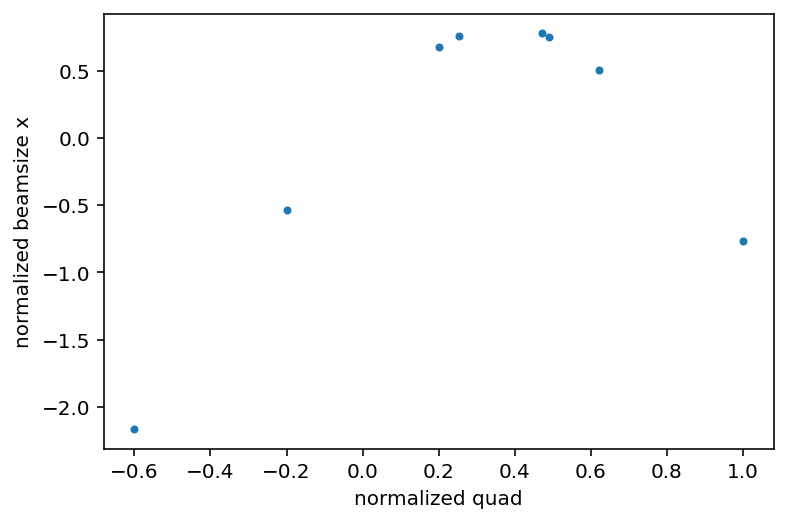

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(-0.5384)
0.31539931595325466


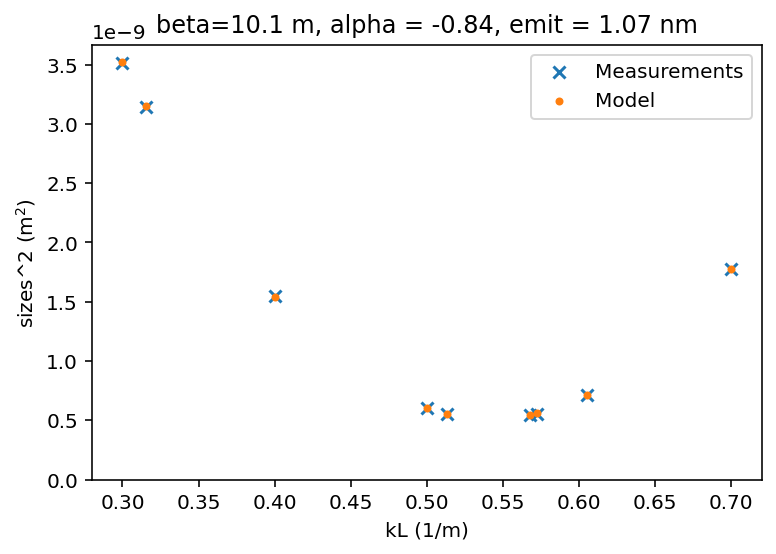

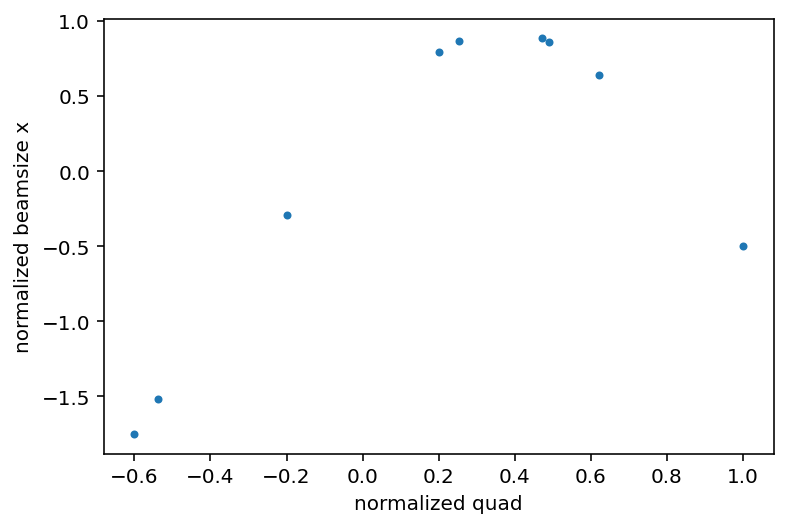

[-1.  1.]
likelihood.noise_covar.raw_noise:Parameter containing:
tensor([2.0000], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:0.0
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
training hyperparameters
optimizing acquisition function
tensor(-0.7273)
0.26818552315235133


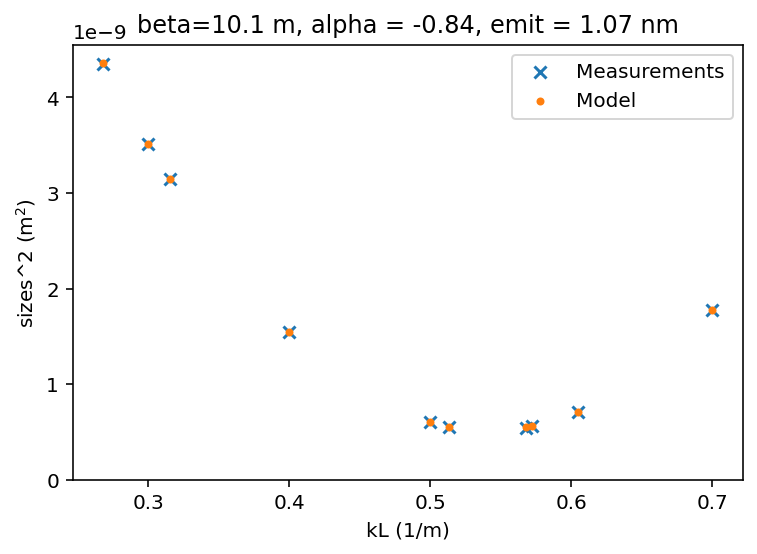

In [955]:
while (len(o1.quad_meas) < number_to_sample/2):
    
    q = nq.normalize_data(o1.quad_meas,grab_stats=False)
    x = nx.normalize_data(o1.beam_meas['x'])
    y = ny.normalize_data(o1.beam_meas['y'])
    
    plt.plot(q,-1*x,'.')
    plt.xlabel('normalized quad')
    plt.ylabel('normalized beamsize x')
    plt.show()

    bounds_n = nq.normalize_data(bounds_full,grab_stats=False)
    print(bounds_n)
    bounds = torch.stack([bounds_n[0]*torch.ones(1), bounds_n[1]*torch.ones(1)])
    
    bayes_opt_next(q,x,y)
    
    ef1 = EmitFitter(o1.quad_meas,o1.beam_meas)
    
    emitx, errx = ef1.do_emit_fit(dim='x')
    #emity, erry = ef1.do_emit_fit(dim='y')


while (len(o1.quad_meas) < number_to_sample):
    
    q = nq.normalize_data(o1.quad_meas,grab_stats=False)
    x = nx.normalize_data(o1.beam_meas['x'])
    y = ny.normalize_data(o1.beam_meas['y'])
    
    plt.plot(q,-1*x,'.')
    plt.xlabel('normalized quad')
    plt.ylabel('normalized beamsize x')
    plt.show()

    bounds_n = nq.normalize_data(bounds_full,grab_stats=False)
    print(bounds_n)
    bounds = torch.stack([bounds_n[0]*torch.ones(1), bounds_n[1]*torch.ones(1)])
    
    bayes_exp_next(q,x,y)
    
    ef1 = EmitFitter(o1.quad_meas,o1.beam_meas)
    
    emitx, errx = ef1.do_emit_fit(dim='x')
   # emity, erry = ef1.do_emit_fit(dim='y')